In [1]:
import numpy as np
import xarray as xr
import glob
import copy
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datadir='data/'
north_str = '300S'
dset1 = '_southof%s_swmt_'%north_str
lstr = 'sigma2'
dl = '005'
dset2 = '_moc_rho2_online_lores'
dset3 = '_dVdt_rho2_online_lores'

In [4]:
ddict = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        if exp == 'control':
            
            for var in ['swmt','psi','Storage change']:
                if var == 'swmt':
                    files = glob.glob(datadir+'%s_piControl'%mod+'_so_*'+dset1+'%s_%s.nc'%(lstr,dl))
                elif var == 'psi':
                    files = glob.glob(datadir+'%s_piControl_global_*'%mod+dset2+'.nc')
                elif var == 'Storage change':
                    files = glob.glob(datadir+'%s_piControl_so_*'%mod+dset3+'.nc')
                    
                if len(files)>1:
                    print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'. Please specify.')
                    print('Loading '+files[0])
                elif len(files)==0:
                    print('ERROR: No file available for '+var+' in '+mod+'-'+exp)
                    ddict[mod]['dVdt' if var =='Storage change' else var] = []
                    continue
                    
                ddict_exp[exp]['dVdt' if var =='Storage change' else var] = \
                    xr.open_dataset(files[0])[var].sel(time=slice(None,'0650'))
                    
        else:
            ddict_mem = {mem:{} for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201'])}
            for mem in ddict_mem:
                for var in ['swmt','psi','Storage change']:
                    if var == 'swmt':
                        files = glob.glob(datadir+'%s_%s_%s'%(mod,exp,mem)+'_so_*'+dset1+'%s_%s.nc'%(lstr,dl))
                    elif var == 'psi':
                        files = glob.glob(datadir+'%s_%s_%s_global_*'%(mod,exp,mem)+dset2+'.nc')
                    elif var == 'Storage change':
                        files = glob.glob(datadir+'%s_%s_%s_so_*'%(mod,exp,mem)+dset3+'.nc')
                        
                    if len(files)>1:
                        print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'-'+mem+'. Please specify.')
                        print('Loading '+files[0])
                    elif len(files)==0:
                        print('ERROR: No file available for '+var+' in '+mod+'-'+exp+'-'+mem)
                        ddict_mem[mem]['dVdt' if var =='Storage change' else var] = []
                        continue
                        
                    ddict_mem[mem]['dVdt' if var =='Storage change' else var] = xr.open_dataset(files[0])[var]
            ddict_exp[exp] = ddict_mem
    ddict[mod] = ddict_exp

In [5]:
tsdict = {mod:{} for mod in list(ddict.keys())}
for mod in tsdict:
    tsdict[mod] = {exp:{} for exp in list(ddict[mod].keys())}
    
for mod in tsdict:
    for exp in tsdict[mod]:
        
        if exp=='control':
            smoc = ddict[mod][exp]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            smoc['sigma2'] = smoc.rho2_i-1000
            smoc = smoc.swap_dims({'rho2_i':'sigma2'})
            psi = (-smoc).sel(yq=[-30], method='nearest').squeeze()
            
            dVdt = ddict[mod][exp]['dVdt'].sel(rho2_i=slice(1033,1038))
            dVdt['sigma2'] = dVdt.rho2_i-1000
            dVdt = dVdt.swap_dims({'rho2_i':'sigma2'})
            
            G = ddict[mod][exp]['swmt']*1e-6
            G_interp = G.interp(sigma2=psi.sigma2,kwargs={'fill_value':0}).groupby('time.year').mean('time')
            G_interp = G_interp.rename({'year':'time'}).assign_coords({'time': psi['time']})
            D = dVdt + psi - G_interp
            
            tsdict[mod][exp]['psi'] = psi
            tsdict[mod][exp]['swmt'] = G_interp
            tsdict[mod][exp]['iwmt'] = D
            tsdict[mod][exp]['dVdt'] = dVdt
    
        else:
            psis = []
            dVdts = []
            Gs = []
            for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
                
                smoc = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
                smoc['sigma2'] = smoc.rho2_i-1000
                smoc = smoc.swap_dims({'rho2_i':'sigma2'})
                psi = (-smoc).sel(yq=[-30], method='nearest').squeeze()
                
                dVdt = ddict[mod][exp][mem]['dVdt'].sel(rho2_i=slice(1033,1038))
                dVdt['sigma2'] = dVdt.rho2_i-1000
                dVdt = dVdt.swap_dims({'rho2_i':'sigma2'})
                
                G = ddict[mod][exp][mem]['swmt']*1e-6
                G_interp = G.interp(sigma2=psi.sigma2,kwargs={'fill_value':0}).groupby('time.year').mean('time')
                
                if mem == '101':
                    #print(mod,mem)
                    psi['time'] = psi.time - timedelta(days=365*(int(mem)-1))
                    dVdt['time'] = dVdt.time - timedelta(days=365*(int(mem)-1))
                
                psi = psi.reset_coords(drop=True)
                psi['mem'] = int(mem)
                psis.append(psi)
                
                dVdt = dVdt.reset_coords(drop=True)
                dVdt['mem'] = int(mem)
                dVdts.append(dVdt)
                
                G_interp = G_interp.rename({'year':'time'}).assign_coords({'time': psi['time']})
                G_interp = G_interp.reset_coords(drop=True)
                G_interp['mem'] = int(mem)
                Gs.append(G_interp)
                
            tsdict[mod][exp]['psi'] = xr.concat(psis, dim='mem')
            tsdict[mod][exp]['swmt'] = xr.concat(Gs, dim='mem')
            tsdict[mod][exp]['dVdt'] = xr.concat(dVdts, dim='mem')
            tsdict[mod][exp]['iwmt'] = tsdict[mod][exp]['dVdt'] + tsdict[mod][exp]['psi'] - tsdict[mod][exp]['swmt']

In [6]:
# define the colormap
#cmap = plt.cm.RdBu_r
cmap = copy.copy(plt.cm.RdBu_r)

# extract all colors from cmap
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the center colors to be white
for x in range(round(cmap.N/2-cmap.N/20),round(cmap.N/2+cmap.N/20)):
    cmaplist[x] = (1,1,1,1.0)
    
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cmap.set_over('maroon')
cmap.set_under('midnightblue')

In [7]:
tctr_cm4 = ['0281', '0380']
tctr_esm4 = ['0121', '0220']
texp = ['0051','0070']

In [8]:
exp = 'antwater'
lttr = [['a','c','e','g'],['b','d','f','h']]
varstrngs = [r'$-\psi$',r'$G_{srf}$',r'$dV/dt$',r'$G_{int}$']
midx = 2
emean = True

In [9]:
import matplotlib.gridspec as gridspec

In [10]:
cstr = ['r', 'k', 'tab:blue', 'g']

### Figure 8

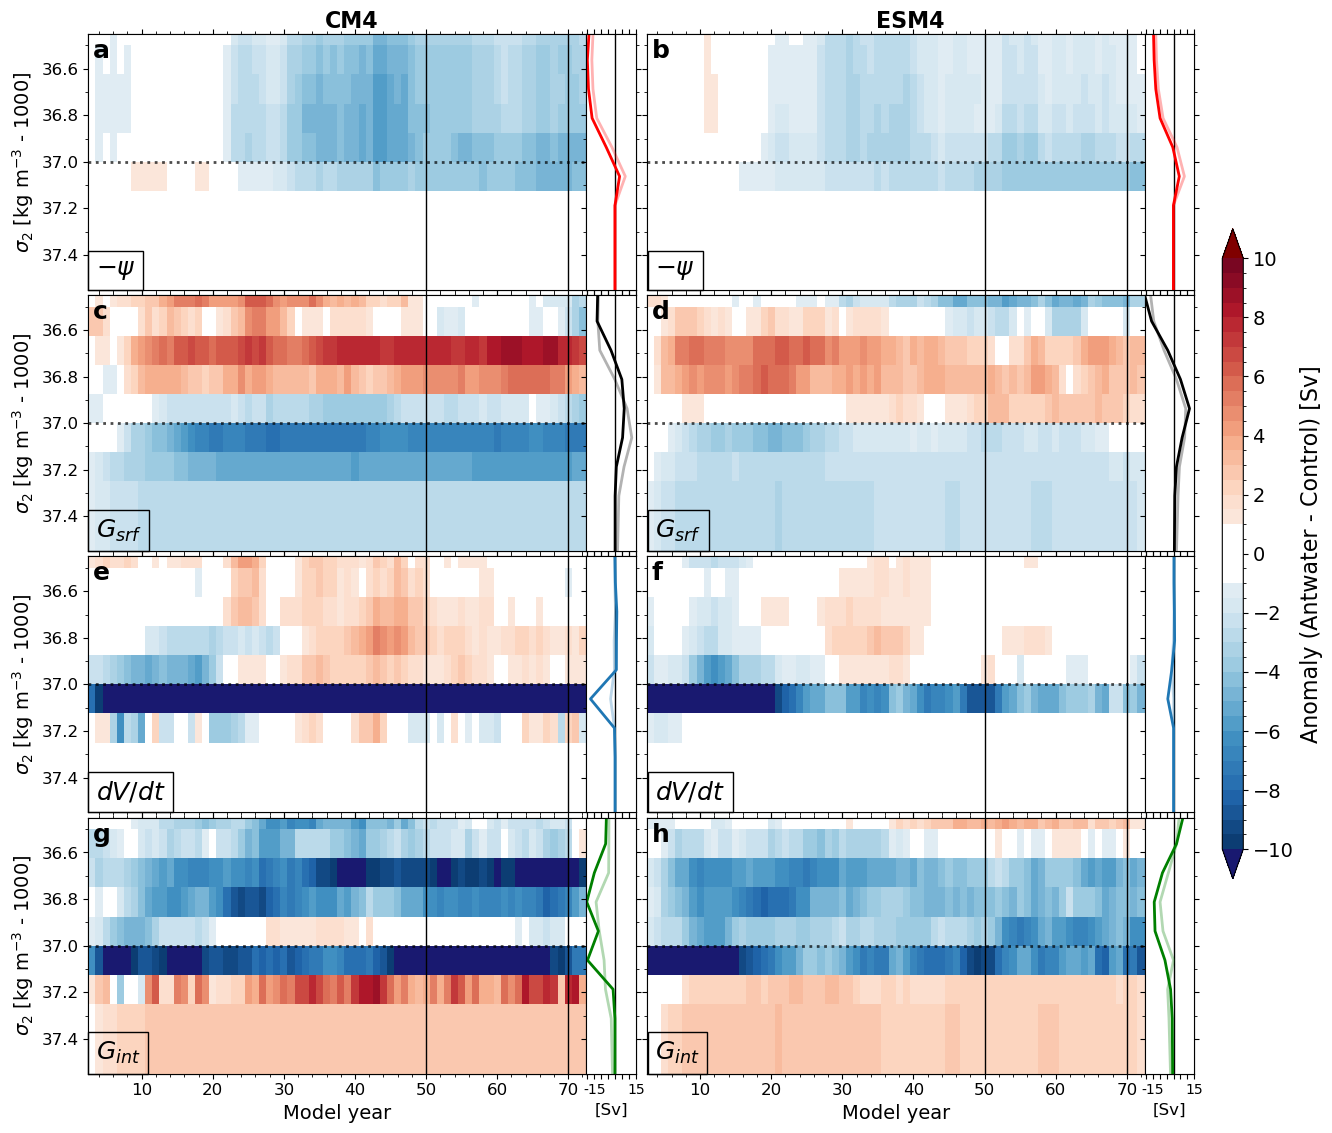

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(14,13))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)

outer_grid = fig.add_gridspec(4, 2)#, wspace=0, hspace=0)
for ax in fig.get_axes():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
for i, mod in enumerate(ddict):
    #print('\n',mod)
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    
    for j, var in enumerate(['psi','swmt','dVdt','iwmt']):
        da_ctrl = tsdict[mod]['control'][var].sel(time=slice(ti,tf)).mean('time')
        
        if emean:
            da = tsdict[mod][exp][var].mean('mem',skipna=True)
            head = mod+'-'+exp
        else:
            da = tsdict[mod][exp][var].isel(mem=midx).dropna(dim='time')
            head = mod+'-'+exp+'-'+str(da.mem.values)
        
        #print(head+':',str(da.time.values[0])[:10],'to',str(da.time.values[-1])[:10])
        
        da_mean = da.sel(time=slice(texp[0],texp[-1])).mean('time')
        da_ann = da.groupby('time.year').mean('time')
        da_anom = da_ann - da_ctrl
        da_anom = da_anom.rolling(year=5,center=True).mean()
        
        inner_grid = outer_grid[j, i].subgridspec(1, 2, wspace=0, hspace=0, width_ratios =[10, 1])
        axs = inner_grid.subplots()  # Create all subplots for the inner grid.
        for k in range(0,len(axs)):
            #print(k)
            
            if k==0:
                p = da_anom.T.plot(ax=axs[k], yincrease=False, vmin=-10, vmax=10, cmap=cmap, levels=41, 
                                   extend='both',add_colorbar=False, add_labels=False)
                axs[k].set_ylim([37.55,36.45])
                axs[k].set_yticks(np.arange(36.5,37.5,0.1), minor=True)
                axs[k].set_xlim([2.5, 72.5])
                axs[k].set_xticks(np.arange(4,74,2), minor=True)
                axs[k].tick_params(axis='both', which='both', labelsize=12, top=True, right=True)
                
                axs[k].text(0.01, 0.98, lttr[i][j], ha='left', va='top', fontsize=18, fontweight='bold',
                            transform=axs[k].transAxes)
                axs[k].text(0.015 if mod=='CM4' else 0.017, 0.03, varstrngs[j], ha='left', va='bottom', 
                            fontsize=18, fontweight='bold', bbox = dict(boxstyle='square', facecolor='none'),
                            transform=axs[k].transAxes)
                axs[k].axvline(x=50.0, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=1)
                axs[k].axvline(x=70.0, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=1)
                axs[k].axhline(y=37.0, xmin=0, xmax=1, c = 'k', lw=2.0, ls=':',alpha=0.7)
                
                if var == 'psi':
                    axs[k].set_title(mod,fontsize=16,x=0.53,y=0.99,fontweight='bold')
                
                if mod != 'CM4':
                    axs[k].set_yticklabels([])
                else:   
                    axs[k].set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
                    
                if var == 'iwmt':
                    axs[k].set_xlabel(r'Model year',fontsize=14)
                else:
                    axs[k].set_xticklabels([])

            elif k==1:
                axs[k].axvline(x=0, ymin=0, ymax=1, linewidth=1.0, color = 'k')
                l_ctr = axs[k].plot(da_ctrl, da_ctrl.sigma2, color=cstr[j], 
                                    ls='-', lw=2, alpha=0.3, label = 'Control')
                l_exp = axs[k].plot(da_mean, da_mean.sigma2, color=cstr[j], 
                                    ls='-', lw=2, label = 'Antwater')
                axs[k].tick_params(axis='both', which='both', labelsize=14, top=True, right=True)
                axs[k].invert_yaxis()
                axs[k].set_ylim([37.55,36.45])
                axs[k].set_yticks(np.arange(36.5,37.5,0.1), minor=True)
                axs[k].set_yticklabels([])
                axs[k].set_xlim([-21,15])
                axs[k].set_xticks(np.arange(-20,20,5))
                if var == 'iwmt':
                    axs[k].set_xticklabels(['','-15','','','','','','15'], fontsize=10)
                    axs[k].set_xlabel(r'[Sv]',fontsize=12)
                else:
                    axs[k].set_xticklabels([])
                
cax = fig.add_axes([0.91, 0.25, 0.015, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-10,12,2), orientation='vertical', extend='both',
                  shrink=0.9, pad=0.02)
cb.set_label('Anomaly (Antwater - Control) [Sv]', fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.savefig('hovmoeller.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Figure 8**: Hovmoeller-type diagrams of annual anomalies in (a,b) $-\psi$, (c,d) $G_{srf}$, (e,f) $dV/dt$ and (g,h) $G_{int}$ in the Antwater experiment relative to the 100-year mean of the Control run. Anomaly time series are presented in discrete density bins corresponding to the density levels of the model's diagnostic output. A 5-yr running mean is applied across each density class. The vertical lines indicate the 20-year averaging period at the end of the experiment used for Figure 7. The dotted horizontal line at $\sigma_{2} = 37.05$ denotes the boundary between AABW and CDW. The sidebar next to each Hovmoeller plot shows the density profile of the corresponding term as shown in Figure 7 a,b, showing both the control (light colored) and the mean (dark colored) of years 51-70 in the Antwater experiment.

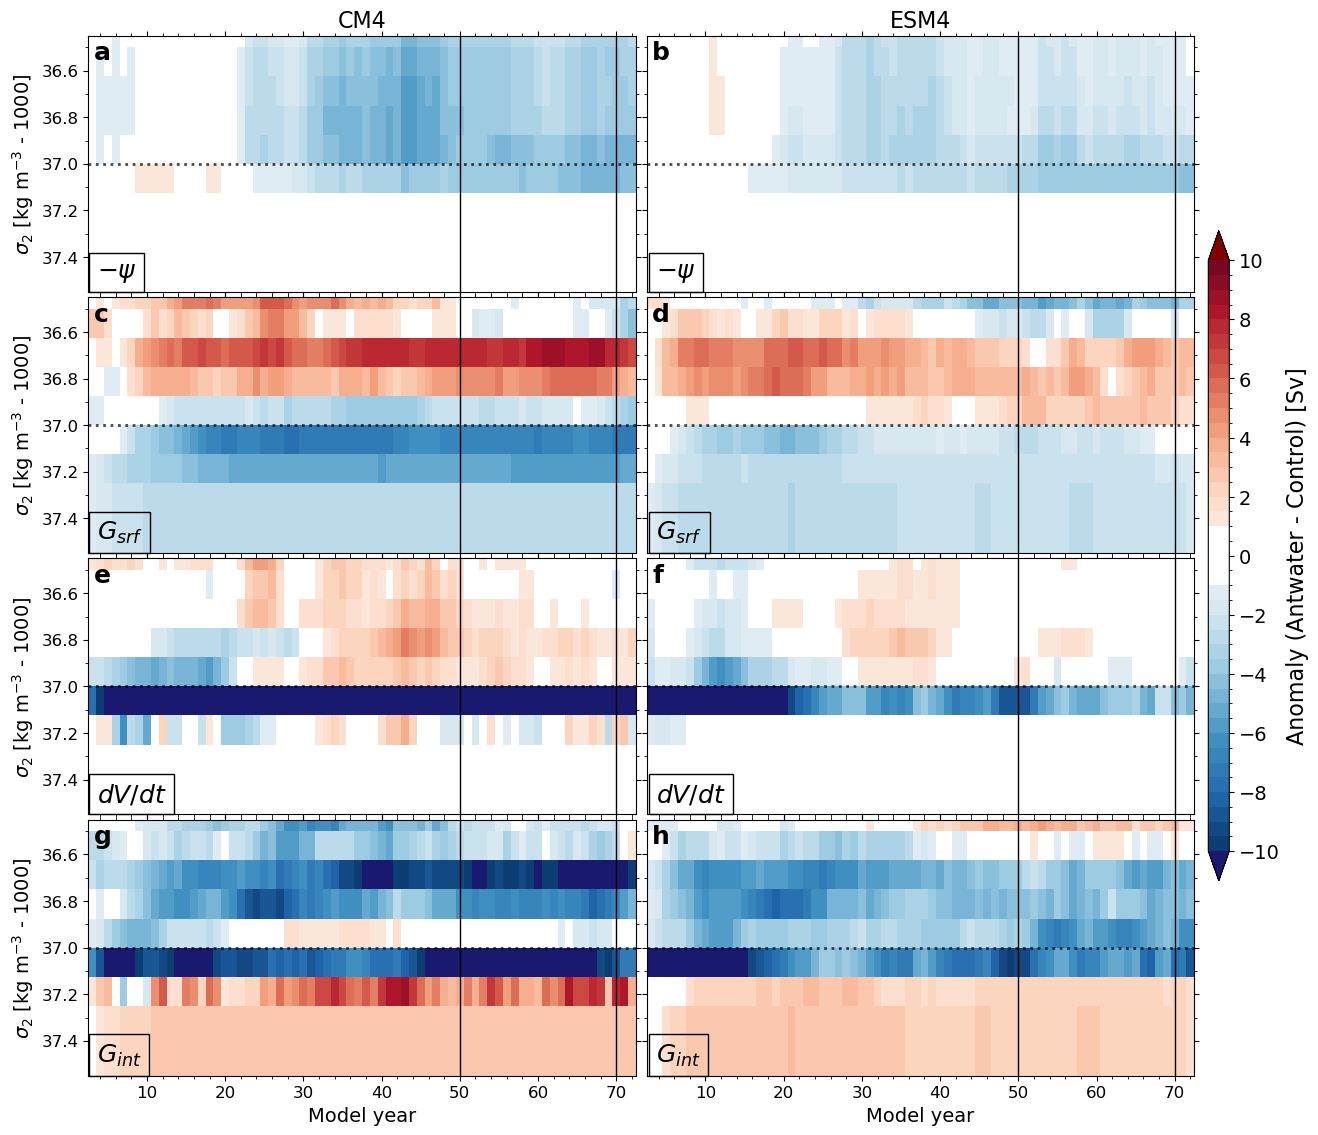

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(14,13))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    
    for j, var in enumerate(['psi','swmt','dVdt','iwmt']):
        
        da_ctrl = tsdict[mod]['control'][var].sel(time=slice(ti,tf)).mean('time')
        
        if emean:
            da = tsdict[mod][exp][var].mean('mem',skipna=True)
            head = mod+'-'+exp
        else:
            da = tsdict[mod][exp][var].isel(mem=midx).dropna(dim='time')
            head = mod+'-'+exp+'-'+str(da.mem.values)
        
        #print(head+':',str(da.time.values[0])[:10],'to',str(da.time.values[-1])[:10])
        
        da_ann = da.groupby('time.year').mean('time')
        da_anom = da_ann - da_ctrl
        da_anom = da_anom.rolling(year=5,center=True).mean()
        
        p = da_anom.T.plot(ax=axs[j,i], yincrease=False, vmin=-10, vmax=10, cmap=cmap, levels=41, extend='both',
                            add_colorbar=False, add_labels=False)
        
        axs[j,i].set_ylim([37.55,36.45])
        axs[j,i].set_yticks(np.arange(36.5,37.5,0.1), minor=True)
        
        axs[j,i].set_xlim([2.5, 72.5])
        axs[j,i].set_xticks(np.arange(4,74,2), minor=True)
        axs[j,i].tick_params(axis='both', which='both', labelsize=12,top=True,right=True)
        axs[j,i].text(0.01, 0.98, lttr[i][j], ha='left', va='top', fontsize=18, fontweight='bold',
                      transform=axs[j,i].transAxes)
        axs[j,i].text(0.015 if mod=='CM4' else 0.017, 0.03, varstrngs[j], ha='left', va='bottom', fontsize=18, 
                      fontweight='bold', bbox = dict(boxstyle='square', facecolor='none'),
                      transform=axs[j,i].transAxes)
        axs[j,i].axvline(x=50.0, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=1)
        axs[j,i].axvline(x=70.0, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=1)
        axs[j,i].axhline(y=37.0, xmin=0, xmax=1, c = 'k', lw=2.0, ls=':',alpha=0.7)
        
        if mod != 'CM4':
            axs[j,i].set_yticklabels([])
        else:   
            axs[j,i].set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if var == 'iwmt':
            axs[j,i].set_xlabel(r'Model year',fontsize=14)
        else:
            axs[j,i].set_xticklabels([])
        
axs[0,0].set_title('CM4',fontsize=16)
axs[0,1].set_title('ESM4',fontsize=16)

cax = fig.add_axes([0.9, 0.25, 0.015, 0.50])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-10,12,2), orientation='vertical', extend='both',
                  shrink=0.9, pad=0.02)
cb.set_label('Anomaly (Antwater - Control) [Sv]', fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()

### Compare experiments

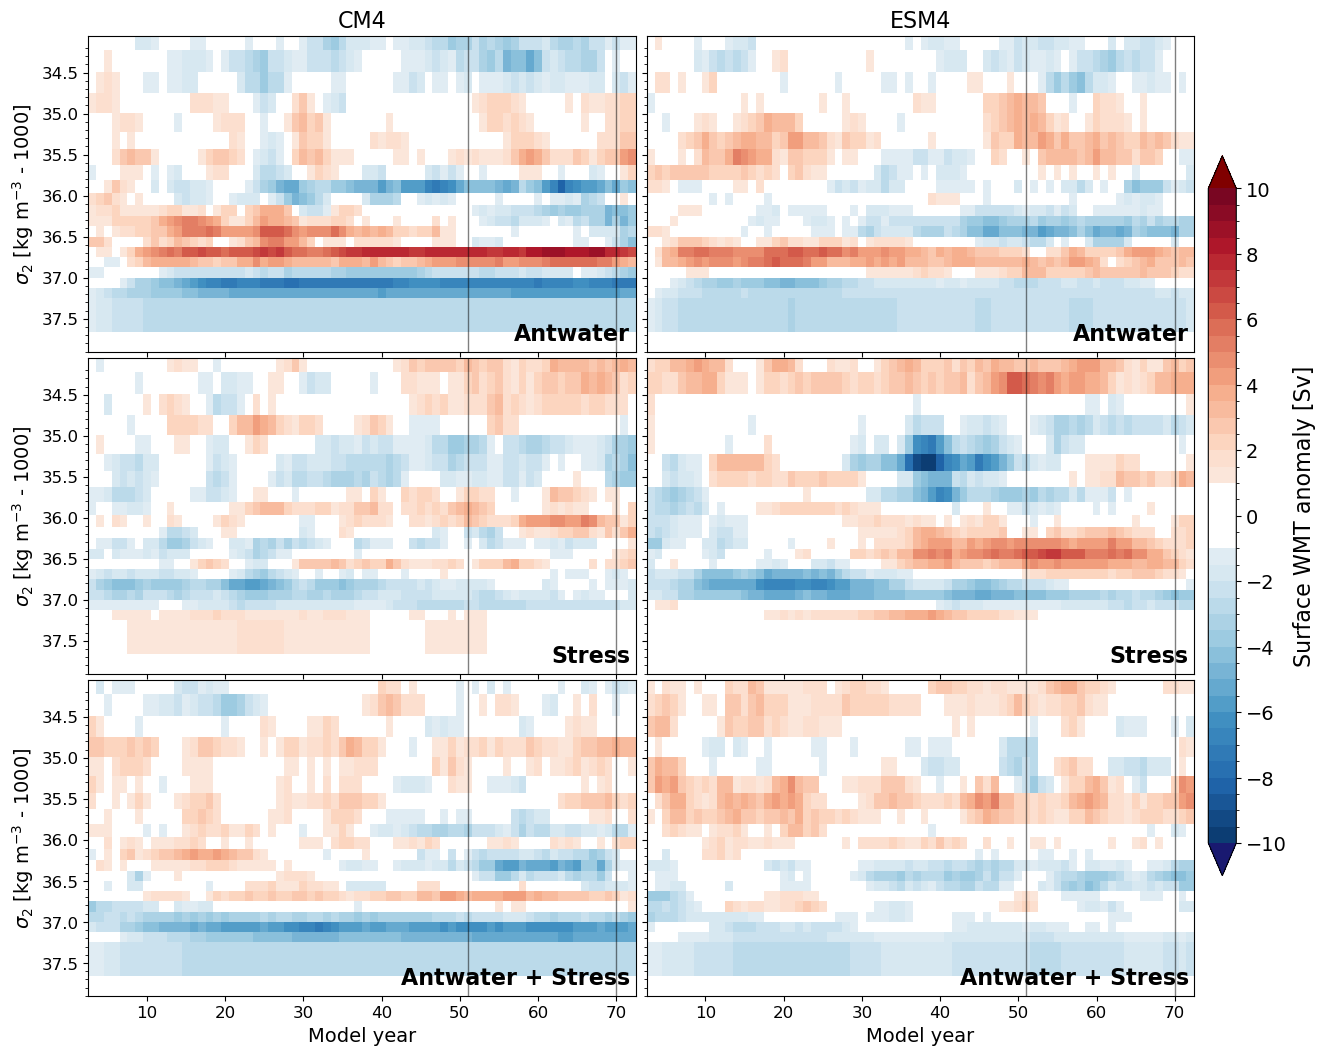

In [13]:
var = 'swmt' # psi, dVdt, swmt, iwmt
midx = 2
emean = True

title_str = 'Overturning anomaly [Sv]' if var=='psi' else 'Storage change anomaly [Sv]' if var=='dVdt' \
                else 'Surface WMT anomaly [Sv]' if var=='swmt' else 'Interior WMT anomaly [Sv]'

fig, axs = plt.subplots(3, 2, figsize=(14,12))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.02, wspace=0.02)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    da_ctrl = tsdict[mod]['control'][var].sel(time=slice(ti,tf)).mean('time')
    
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        
        if emean:
            da = tsdict[mod][exp][var].mean('mem',skipna=True)
            head = mod+'-'+exp
        else:
            da = tsdict[mod][exp][var].isel(mem=midx).dropna(dim='time')
            head = mod+'-'+exp+'-'+str(da.mem.values)
        
        #print(head+':',str(da.time.values[0])[:10],'to',str(da.time.values[-1])[:10])
        
        da_ann = da.groupby('time.year').mean('time')
        da_anom = da_ann - da_ctrl
        da_anom = da_anom.rolling(year=5,center=True).mean()
        
        p = da_anom.T.plot(ax=axs[j,i], yincrease=False, vmin=-10, vmax=10, cmap=cmap, levels=41, extend='both',
                            add_colorbar=False, add_labels=False)
        
        axs[j,i].set_ylim([37.8,34.05])
        axs[j,i].set_yticks(np.arange(34.2,38,0.1), minor=True)
        
        axs[j,i].set_xlim([2.5, 72.5])
        axs[j,i].set_xticks(np.arange(10,80,10), minor=True)
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].text(0.99, 0.02, exp[:8].capitalize()+' + '+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), ha='right', va='bottom', fontsize=16, 
                      fontweight='bold',transform=axs[j,i].transAxes)
        axs[j,i].axvline(x=51, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=0.5)
        axs[j,i].axvline(x=70, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=0.5)
        
        if mod != 'CM4':
            axs[j,i].set_yticklabels([])
        else:   
            axs[j,i].set_ylabel('$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if exp == 'antwaterstress':
            axs[j,i].set_xlabel(r'Model year',fontsize=14)
        else:
            axs[j,i].set_xticklabels([])
        
axs[0,0].set_title('CM4',fontsize=16)
axs[0,1].set_title('ESM4',fontsize=16)

cax = fig.add_axes([0.9, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-10,12,2), orientation='vertical', extend='both',
                  shrink=0.9, pad=0.02)
cb.set_label(title_str, fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()

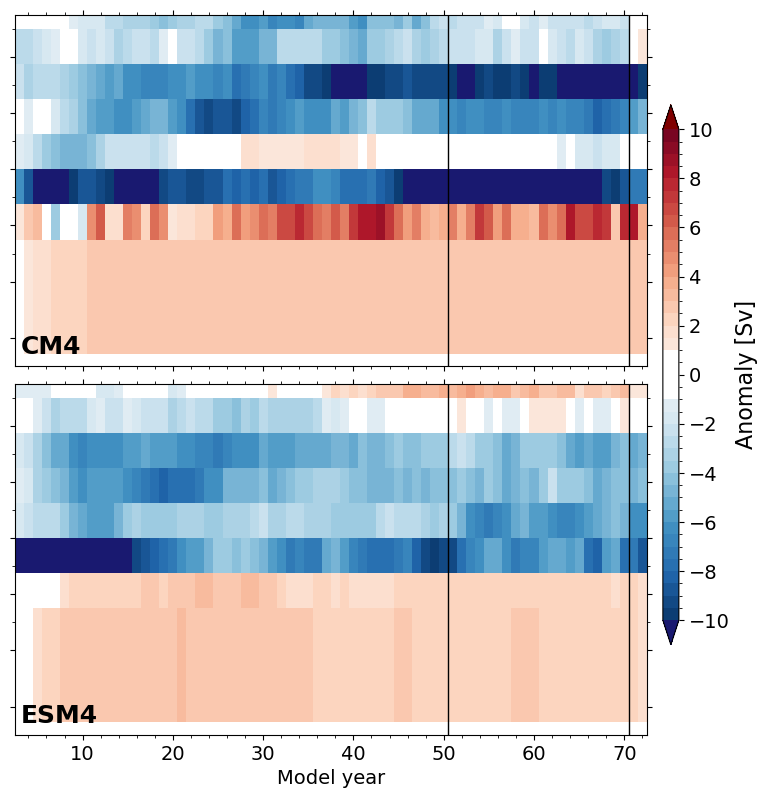

In [17]:
var = 'iwmt' # psi, dVdt, swmt, iwmt
exp = 'antwater'

fig, axs = plt.subplots(2, 1, figsize=(8,9))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace = 0.05)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    da_ctrl = tsdict[mod]['control'][var].sel(time=slice(ti,tf)).mean('time')
    
    da = tsdict[mod][exp][var].mean('mem',skipna=True)
    da_ann = da.groupby('time.year').mean('time')
    da_anom = da_ann - da_ctrl
    da_anom = da_anom.rolling(year=5,center=True).mean()
    
    p = da_anom.T.plot(ax=axs[i], yincrease=False, vmin=-10, vmax=10, cmap=cmap, levels=41, extend='both',
                       add_colorbar=False, add_labels=False)
    axs[i].set_ylim([36.45,37.7])
    axs[i].set_yticks(np.arange(36.5,37.5,0.1), minor=True)
    axs[i].set_yticklabels([])
    axs[i].invert_yaxis()
    axs[i].tick_params(axis='both', which='both', labelsize=14,top=True,right=True)
    axs[i].set_xlim([2.5, 72.5])
    axs[i].set_xticks(np.arange(4,74,2), minor=True)
    axs[i].axvline(x=50.5, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=1)
    axs[i].axvline(x=70.5, ymin=0, ymax=1, c = 'k', lw=1.0, ls='-',alpha=1)
    axs[i].text(0.01, 0.02, mod, ha='left', va='bottom', fontsize=18, fontweight='bold',
                transform=axs[i].transAxes)
    
    if mod == 'ESM4':
        axs[i].set_xlabel(r'Model year',fontsize=14)
    else:
        axs[i].set_xticklabels([])
    
cax = fig.add_axes([0.91, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-10,12,2), orientation='vertical', extend='both',
                  shrink=0.9, pad=0.02)
cb.set_label('Anomaly [Sv]', fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()